In [38]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import convolve1d

# Correspondance des mesures de forage

| **Code**  | **Description** | **Unité de mesure** |
|-----------|---------------|---------------------|
| **TIME**  | Temps d'enregistrement des données | hh:mm:ss ou s |
| **DBTM**  | Profondeur mesurée | m (mètres) |
| **DMEA**  | Profondeur vraie verticale (TVD) | m (mètres) |
| **SPPA**  | Pression de surface | psi ou bar |
| **BPOS**  | Position du trépan | m (mètres) |
| **SPM1**  | Vitesse de la pompe 1 | spm (coups par minute) |
| **SPM2**  | Vitesse de la pompe 2 | spm (coups par minute) |
| **MFIA**  | Débit de fluide de forage | L/min ou gpm (gallons par minute) |
| **WOBA**  | Poids sur le trépan (WOB) | klbf (kilopounds-force) ou daN |
| **HKLA**  | Tension sur le crochet | klbf (kilopounds-force) ou daN |
| **RPMA**  | Vitesse de rotation du trépan | tr/min (RPM) |
| **TQA**   | Couple appliqué | kNm (kilonewton-mètre) |
| **TV01-TV06** | Température mesurée à différents capteurs | °C |
| **TTV1**  | Température de la boue de forage | °C |
| **ROPA**  | Taux de pénétration (ROP) | m/h ou ft/h |

In [39]:
os.listdir('../DATA')

['Anatole_processed_Anatole_processed_concatenated.par.parquet',
 'Anatole_processed_Anatole_processed_Data Export_CORIANCE.parquet',
 'Anatole_processed_Anatole_processed_Data Export_CORIANCE_GAL3_13022025-23h-23h59.par.parquet',
 'Anatole_processed_Anatole_processed_Data Export_CORIANCE_GAL3_14022025-00h-23h59.par.parquet',
 'Anatole_processed_Anatole_processed_Data Export_CORIANCE_GAL3_19022025-00h-23h59.par.parquet',
 'Anatole_processed_Anatole_processed_Data Export_CORIANCE_GAL3_20022025-00h-23h59.par.parquet',
 'Anatole_processed_Anatole_processed_Data Export_CORIANCE_GAL3_21022025-00h-23h59.par.parquet',
 'Anatole_processed_Anatole_processed_Data Export_CORIANCE_GAL3_22022025-00h-23h59.par.parquet',
 'Anatole_processed_Anatole_processed_Data Export_CORIANCE_GAL3_23022025-00h-23h59.par.parquet',
 'Anatole_processed_concatenated.parquet',
 'Anatole_processed_Data Export_CORIANCE.zip',
 'Anatole_processed_Data Export_CORIANCE_GAL3_13022025-23h-23h59.parquet',
 'Anatole_processed_Da

In [40]:
data = [pd.read_csv('../DATA/' + f) for f in os.listdir('../DATA') if f.endswith('.csv')] 

In [41]:
# for df in data:
#     df['TIME'] = pd.to_datetime(df['TIME'])

Prétraitement

In [42]:
initial_negatives = 0

for df in data:
    initial_negatives += (df.select_dtypes(include=[np.number]) < 0).sum().sum()
    df[df.select_dtypes(include=[np.number]).columns] = df.select_dtypes(include=[np.number]).applymap(lambda x: 0 if x < 0 else x)

print(f"Nombre de valeurs initialement négatives: {initial_negatives}")

C:\Users\anato\AppData\Local\Temp\ipykernel_39088\632738541.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[df.select_dtypes(include=[np.number]).columns] = df.select_dtypes(include=[np.number]).applymap(lambda x: 0 if x < 0 else x)


Nombre de valeurs initialement négatives: 59406


In [43]:
def lisseur(df, window=3):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].rolling(window=window, min_periods=1).mean()
    return df

def derivee_variable(df, value_col, time_col="TIME"):
    # Convert TIME column to datetime if not already in datetime format
    df[time_col] = pd.to_datetime(df[time_col])
    
    # Conversion en secondes pour avoir un pas en unité de temps homogène
    dt = df[time_col].diff().dt.total_seconds()
    
    # Calcul des dérivées avec différences finies centrées
    d_forward = (df[value_col].shift(-1) - df[value_col]) / dt.shift(-1)  # Vers l'avant
    d_backward = (df[value_col] - df[value_col].shift(1)) / dt  # Vers l'arrière

    # Moyenne des dérivées pour une approximation centrée
    df["DERIV"+value_col] = (d_forward + d_backward) / 2

    return df


data_prepro = [lisseur(df) for df in data]
data_prepro = [derivee_variable(df, "BPOS") for df in data_prepro]

def variation(df, value_col, lim_var=0, time_col="TIME"):
    df_a = derivee_variable(df, value_col, time_col)
    df_a["ASC"+value_col] = (df_a["DERIV"+value_col] > lim_var).astype(bool)
    df_a["DESC"+value_col] = (df_a["DERIV"+value_col] < -lim_var).astype(bool)
    return df_a

def constant(df, value_col):
    df["CONST"+value_col] = ((df["DESC"+value_col] == False) & (df["ASC"+value_col] == False)).astype(bool)
    return df

def charge(df, lim_var=20):
    df['CHARGE'] = (df["HKLA"] > lim_var).astype(bool)
    return df

def forage(df, lim_var=0):
    df['FORAGE'] = (df["WOBA"] > lim_var).astype(bool)
    return df

def pompage(df):
    df['CIRCULATION'] = ((df["WOBA"] > 0) & (df["SPM2"] > 0) & (df["SPPA"] > 6) & (df["MFIA"] > 0)).astype(bool)
    return df

data_prepro = [variation(df, "BPOS") for df in data_prepro]
data_prepro = [constant(df, "BPOS") for df in data_prepro]
data_prepro = [charge(df) for df in data_prepro]
data_prepro = [forage(df) for df in data_prepro]
data_prepro = [pompage(df) for df in data_prepro]

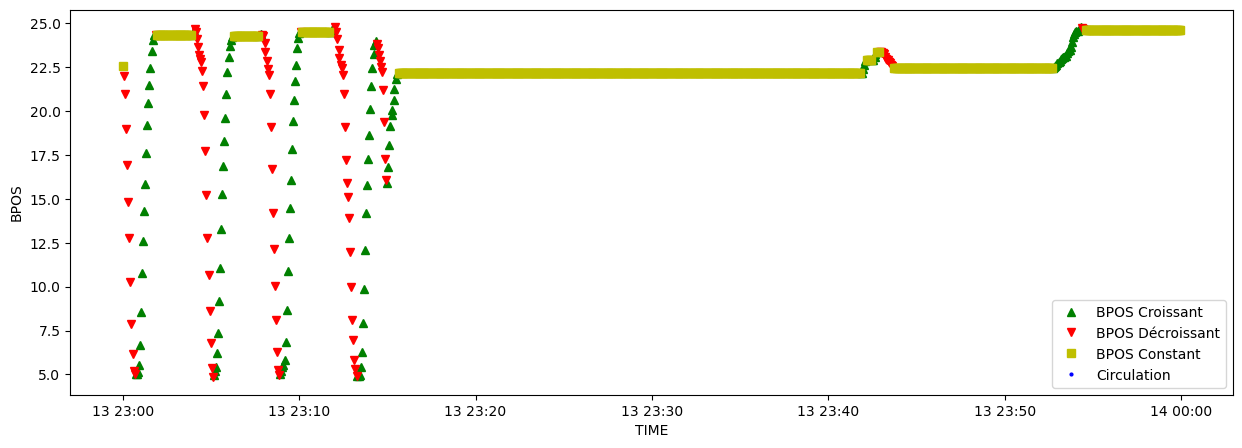

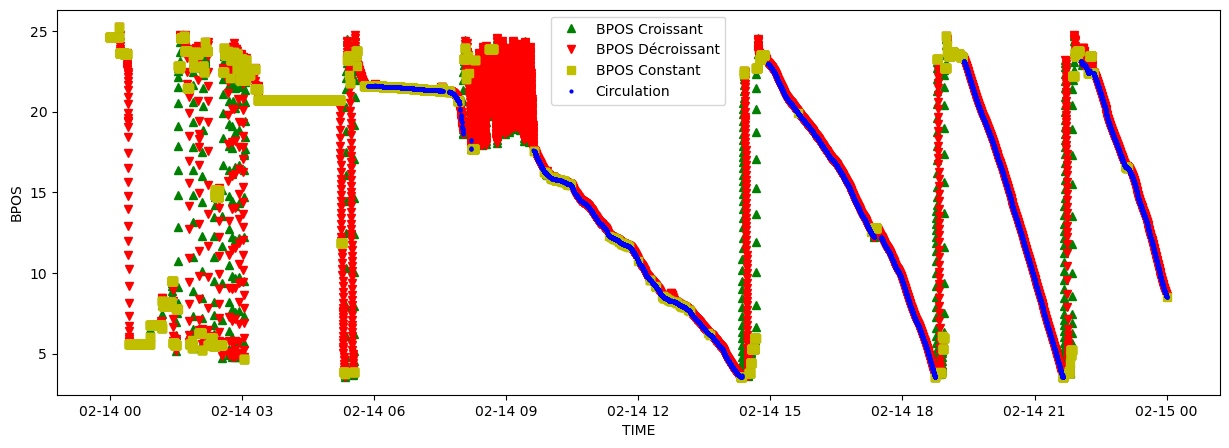

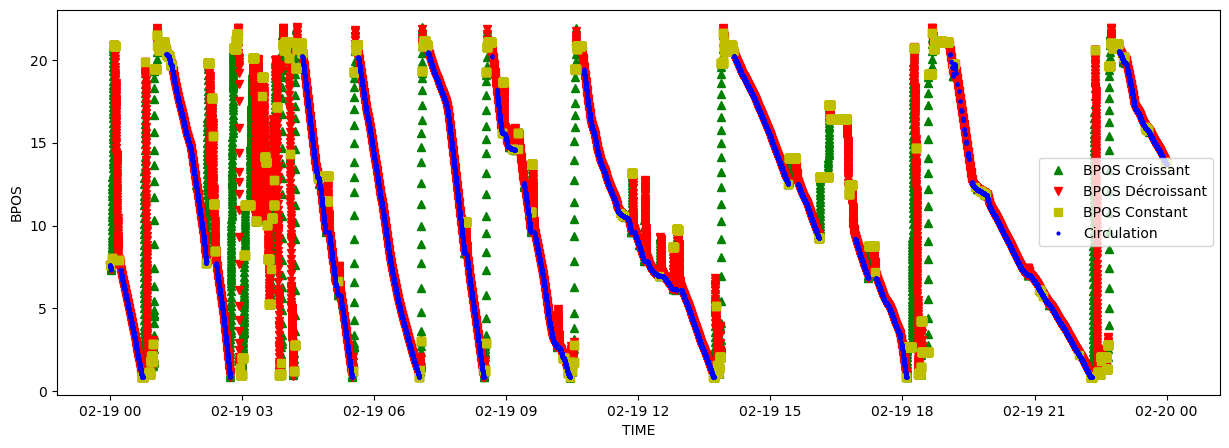

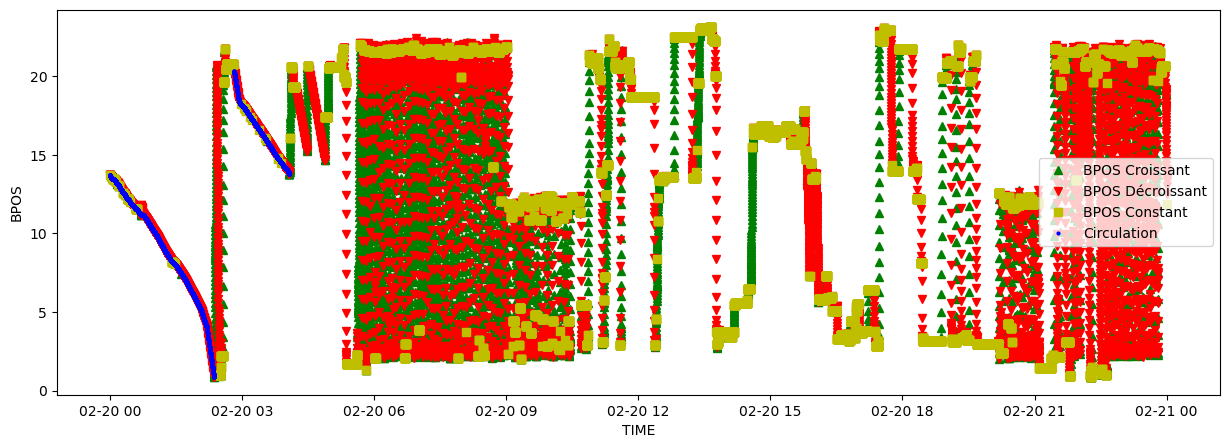

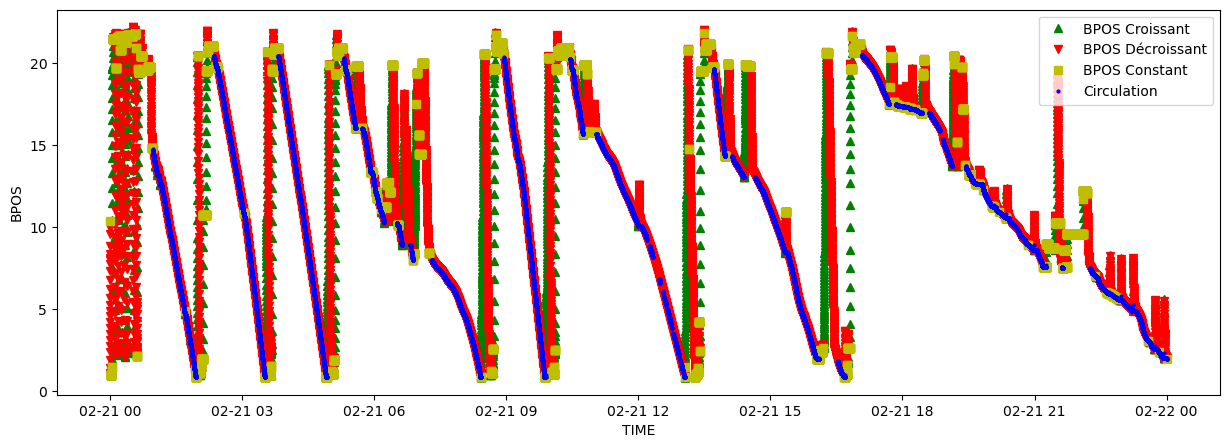

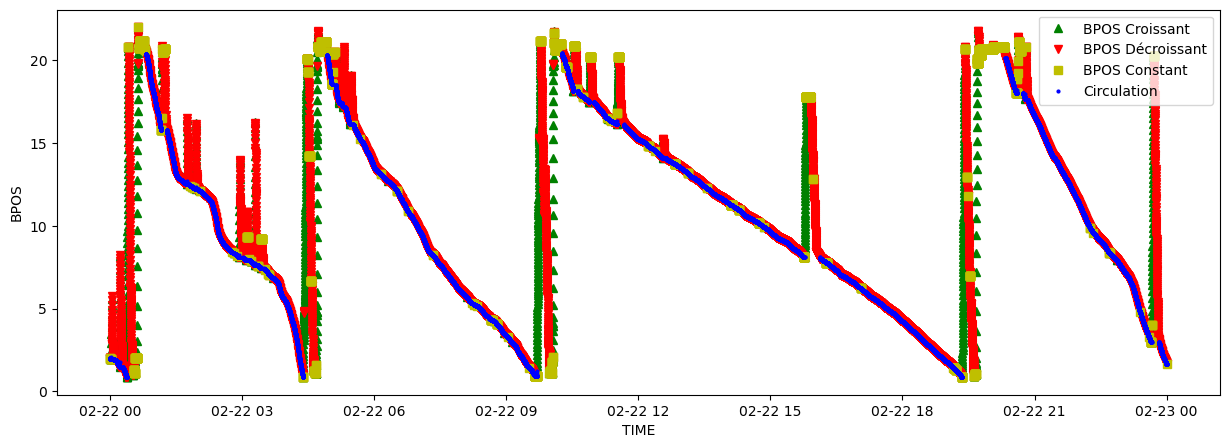

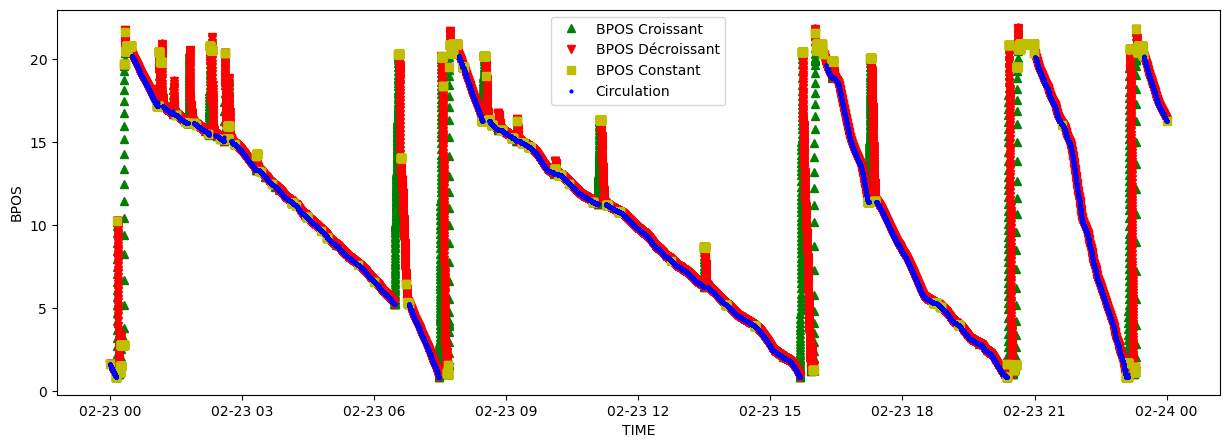

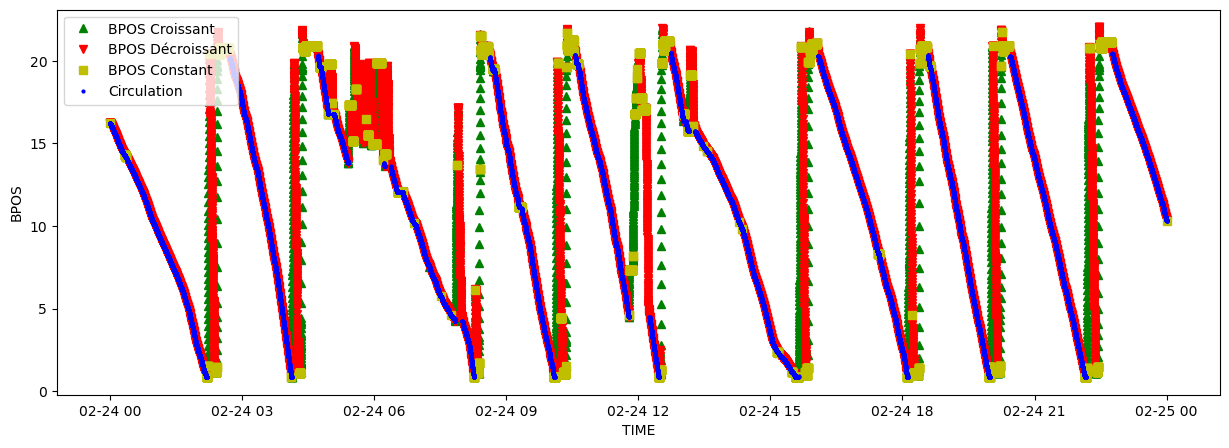

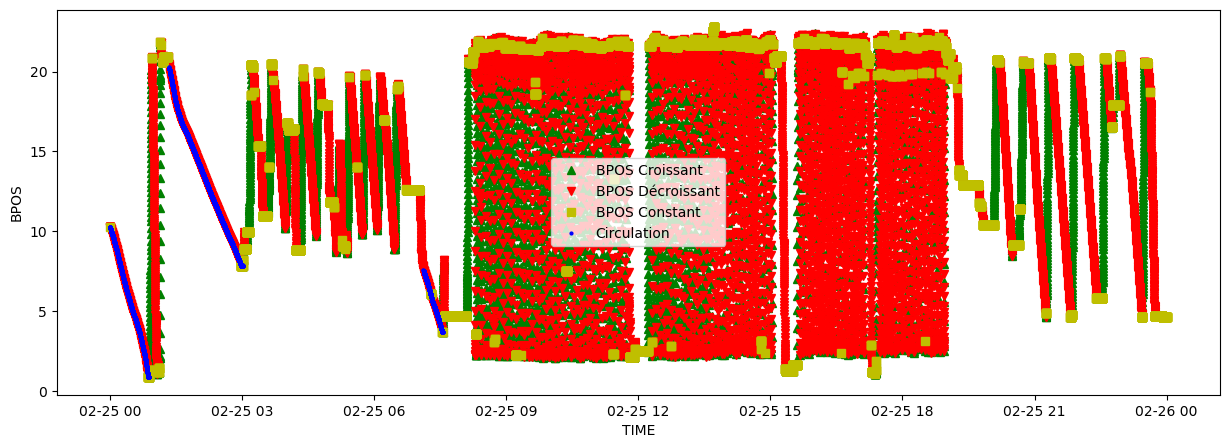

In [44]:
for i in range(len(data)):
    plt.figure(figsize=(15, 5))
    
    # Tracer les points croissants
    plt.plot(data_prepro[i]['TIME'][data_prepro[i]['ASC' + 'BPOS']], data_prepro[i]['BPOS'][data_prepro[i]['ASC' + 'BPOS']], 'g^', label='BPOS Croissant')
    
    # Tracer les points décroissants
    plt.plot(data_prepro[i]['TIME'][data_prepro[i]['DESC' + 'BPOS']], data_prepro[i]['BPOS'][data_prepro[i]['DESC' + 'BPOS']], 'rv', label='BPOS Décroissant')
    
    # Tracer les points constants
    plt.plot(data_prepro[i]['TIME'][data_prepro[i]['CONST' + 'BPOS']], data_prepro[i]['BPOS'][data_prepro[i]['CONST' + 'BPOS']], 'ys', label='BPOS Constant')
    
    # Tracer les points avec circulation
    plt.plot(data_prepro[i]['TIME'][data_prepro[i]['CIRCULATION']], data_prepro[i]['BPOS'][data_prepro[i]['CIRCULATION']], 'bo',markersize=2, label='Circulation')
    
    # # Tracer les points sans circulation
    # plt.plot(data_prepro[i]['TIME'][~data_prepro[i]['CIRCULATION']], data_prepro[i]['BPOS'][~data_prepro[i]['CIRCULATION']], 'k1', markersize=3, label='Pas de Circulation')
    plt.legend()
    plt.xlabel('TIME')
    plt.ylabel('BPOS')    

In [45]:

# data_processed = data_prepro
# for i, name in enumerate(os.listdir('../DATA')):
#     data_processed[i].to_parquet('../DATA/Anatole_processed_'+name[:-4]+'.parquet')
#     print(name[:-4]+'.parquet')

In [46]:
data_processed_concatenated = pd.concat(data_processed)

In [49]:
def determine_state(row):
    state=str()
    if row['ASCBPOS'] and row['CHARGE']:
        state+= "Montée en charge"
    elif row['ASCBPOS'] and ~row['CHARGE']:
        state+= "Montée à vide"
    elif row['DESCBPOS'] and row['CHARGE']:
        state+= "Descente en charge"
    elif row['DESCBPOS'] and ~row['CHARGE']:
        state+= "Descente à vide"
    if row['FORAGE']:
        state+= "+Forage"
    else:
        state+= "+Stand By"
    if row["CIRCULATION"]:
        state += "circulation"
    if not state:
        state = "En attente"
    return state

data_processed_concatenated["str_etat"] = data_processed_concatenated.apply(determine_state, axis=1)


C:\Users\anato\AppData\Local\Temp\ipykernel_39088\259704857.py:9: DeprecationWarning: Bitwise inversion '~' on bool is deprecated. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif row['DESCBPOS'] and ~row['CHARGE']:
C:\Users\anato\AppData\Local\Temp\ipykernel_39088\259704857.py:5: DeprecationWarning: Bitwise inversion '~' on bool is deprecated. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif row['ASCBPOS'] and ~row['CHARGE']:


In [51]:
data_processed_concatenated.to_parquet('../DATA/Anatole_processed_concatenated_plusEtat.parquet')

In [ ]:
# data_processed_concatenated.to_parquet('../DATA/Anatole_processed_concatenated.parquet')

In [ ]:
data_processed_concatenated.shape

(309896, 27)

In [ ]:
data

In [ ]:
data_prepro[0]

,TIME,DBTM,DMEA,SPPA,BPOS,SPM1,SPM2,MFIA,WOBA,HKLA,...,TV06,TTV1,ROPA,DERIVBPOS,ASCBPOS,DESCBPOS,CONSTBPOS,CHARGE,FORAGE,CIRCULATION
0,2025-02-13 23:00:01,18.70372,222.2,3.000000,22.575900,0.0,0.0,0.0,0.0,12.951000,...,0.0000,0.000521,0.0,NaN,False,False,True,False,False,False
1,2025-02-13 23:00:04,18.70372,222.2,1.500000,21.974200,0.0,0.0,0.0,0.0,13.090650,...,0.0000,0.000521,0.0,-0.224908,False,True,False,False,False,False
2,2025-02-13 23:00:08,18.70372,222.2,1.333333,20.977200,0.0,0.0,0.0,0.0,12.429600,...,0.0000,0.000521,0.0,-0.462153,False,True,False,False,False,False
3,2025-02-13 23:00:11,18.70372,222.2,1.000000,18.952033,0.0,0.0,0.0,0.0,12.001300,...,0.0000,0.000347,0.0,-0.592378,False,True,False,False,False,False
4,2025-02-13 23:00:15,18.70372,222.2,2.000000,16.913233,0.0,0.0,0.0,0.0,12.187500,...,0.0000,0.000174,0.0,-0.513837,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2025-02-13 23:59:42,18.70372,222.2,3.000000,24.626400,0.0,0.0,0.0,0.0,15.464833,...,21.2717,0.000174,0.0,0.000000,False,False,True,False,False,False
997,2025-02-13 23:59:45,18.70372,222.2,3.333333,24.626400,0.0,0.0,0.0,0.0,14.384800,...,21.2703,0.000347,0.0,0.000000,False,False,True,False,False,False
998,2025-02-13 23:59:49,18.70372,222.2,4.000000,24.626400,0.0,0.0,0.0,0.0,13.118567,...,21.2717,0.000347,0.0,0.000000,False,False,True,False,False,False
999,2025-02-13 23:59:52,18.70372,222.2,4.333333,24.626400,0.0,0.0,0.0,0.0,13.677200,...,21.2717,0.000174,0.0,0.000000,False,False,True,False,False,False


In [ ]:
df_test=data[1]

In [ ]:
df_test

In [52]:
# for i in range(len(data)):
#     plt.figure(figsize=(15, 5))  # Adjust the figure size
#     plt.plot(data[i]['TIME'][::2], data[i]['HKLA'][::2], label='HKLA = Tension crochet', c='r')
#     plt.plot(data[i]['TIME'][::2], data[i]['BPOS'][::2], label='BPOS = Position trépan', c='b')
#     plt.legend()

#     # Réduire le nombre de ticks sur l'axe des x
#     plt.xticks(ticks=np.arange(0, len(data[i]['TIME'][::2]), len(data[i]['TIME'][::2]) // 3), rotation=45)
#     plt.show()

In [53]:
# for i in range(len(data)):
#     plt.figure(figsize=(15, 5))  # Adjust the figure size
#     plt.plot(data[i]['TIME'][::2], data[i]['WOBA'][::2], label='WOBA = Poids trépan', c='r')
#     plt.plot(data[i]['TIME'][::2], data[i]['SPM1'][::2], label='SPM1 = Vitesse pompe 1', c='b')
#     plt.plot(data[i]['TIME'][::2], data[i]['SPM2'][::2], label='SPM2 = Vitesse Pompe 2', c='g')
#     plt.plot(data[i]['TIME'][::2], data[i]['SPPA'][::2], label='SPPA = Pression de surface', c='black')
#     plt.legend()

#     # Réduire le nombre de ticks sur l'axe des x
#     plt.xticks(ticks=np.arange(0, len(data[i]['TIME'][::2]), len(data[i]['TIME'][::2]) // 3), rotation=45)
#     plt.show()

In [54]:
# filter = [data[i]['MFIA'] > 0 for i in range(len(data))]
# for i in range(len(data)):
#     plt.figure(figsize=(15, 5))  # Adjust the figure size
#     plt.plot(data[i]['TIME'][filter[i]][::2], data[i]['MFIA'][filter[i]][::2], label='MFIA = Débit du fluide', c='purple')
#     plt.legend()

#     # Réduire le nombre de ticks sur l'axe des x
#     plt.xticks(ticks=np.arange(0, len(data[i]['TIME'][::2]), len(data[i]['TIME'][::2]) // 3), rotation=45)
    
#     # Ajouter la valeur minimale de MFIA aux ticks de l'axe des y
#     min_mfia = data[i]['MFIA'][filter[i]].min()
#     if not np.isnan(min_mfia):
#         current_yticks = plt.yticks()[0]
#         plt.yticks(np.append(current_yticks, min_mfia))
    
#     plt.show()